In [1]:
!pip install einops
!pip install timm

     |████████████████████████████████| 431 kB 5.1 MB/s 


In [2]:
import torch
import torch.nn as nn
import numpy as np
import einops
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, trunc_normal_
from torchsummary import summary

In [3]:
class Mlp(nn.Module):
  def __init__(self, in_features, hidden_features = None, out_features = None, act_layer = nn.GELU, drop = 0.):
    super().__init__()
    out_features = out_features or in_features
    hidden_features = hidden_features or in_features
    self.fc1 = nn.Linear(in_features, hidden_features)
    self.act = act_layer()
    self.fc2 = nn.Linear(hidden_features, out_features)
    self.drop = nn.Dropout(drop)

  def forward(self,x):
    x = self.fc1(x)
    x = self.act(x)
    x = self.drop(x)
    x = self.fc2(x)
    x = self.drop(x)
    return x

In [36]:
class WindowAttention(nn.Module):
  def __init__(self,dim,window_size,num_heads,qkv_bias=True,qk_scale = None, attn_drop = 0., proj_drop = 0.):
    super().__init__()
    self.dim = dim
    self.window_size = window_size
    self.num_heads = num_heads
    head_dim = dim // num_heads
    self.scale = qk_scale or head_dim ** -0.5

    # define a parameter table of relative position bias
    self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

    # get pair-wise relative position index for each token inside the window
    coords_h = torch.arange(self.window_size)
    coords_w = torch.arange(self.window_size)
    coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += self.window_size - 1  # shift to start from 0
    relative_coords[:, :, 1] += self.window_size - 1
    relative_coords[:, :, 0] *= 2 * self.window_size - 1
    relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
    self.register_buffer('relative_position_index', relative_position_index)

    self.qkv = nn.Linear(dim, dim*3, bias = qkv_bias)
    self.attn_drop = nn.Dropout(attn_drop)
    self.proj = nn.Linear(dim,dim)
    self.proj_drop = nn.Dropout(proj_drop)

    trunc_normal_(self.relative_position_bias_table, std=.02)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self,x,mask=None):
    b,n,c = x.shape
    qkv = self.qkv(x).chunk(3,dim=-1)
    q,k,v = [einops.rearrange(t,'b n (h c) -> b h n c',h=self.num_heads) for t in qkv]

    q = q * self.scale
    attn = torch.einsum('bhqd, bhkd -> bhqk', q,k) 
    
    relative_position_bias = self.relative_position_bias_tableo[self.relative_positin_index.view(-1)].view(self.window_size**2, self.window_size**2, -1)#wh*ww, wh*ww, nh
    relative_position_bias = relative_position_bias.permute(2,0,1) # nh, wh*ww,wh*ww
    attn = attn + relative_position_bias.unsqueeze(0)

    if mask is not None:
      nW = mask.shape[0]
      attn = attn.reshape(b // nW, nW, self.num_heads, n,n) + mask.unsqueeze(1).unsqueeze(0)
      attn = attn.view(-1, self.num_heads,n,n)
      attn = self.softmax(attn)
    else:
      attn = self.softmax(attn)
    attn = self.attn_drop(attn)
    x = torch.einsum('bhan,bhnv -> bhav',attn,v).reshape(b,-1,c)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x


In [5]:
class PatchEmbed(nn.Module):
  def __init__(self, img_size = 224, patch_size=4, in_channels=3,embed_dim=96, norm_layer = None):
    super().__init__()
    patch_resolution = [img_size//patch_size, img_size//patch_size]
    self.img_size = img_size
    self.patch_size = patch_size
    self.patch_resolution = patch_resolution
    self.num_patches = patch_resolution[0] * patch_resolution[1]

    self.in_channels = in_channels
    self.embed_dim = embed_dim

    self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size = patch_size, stride = patch_size)
    if norm_layer is not None:
      self.norm = norm_layer(embed_dim)
    else:
      self.norm = None

  def forward(self,x):
    b,c,h,w = x.shape
    assert h == self.img_size and w == self.img_size
    x = self.proj(x).flatten(2).transpose(1,2) # b, ph*pw, c
    if self.norm is not None:
      x = self.norm(x)
    return x

In [33]:
class PatchMergnig(nn.Module):
  def __init__(self, input_resolution, dim, norm_layer = nn.LayerNorm):
    super().__init__()
    self.input_resolution = input_resolution
    self.dim = dim
    self.reduction = nn.Linear(4*dim, 2*dim, bias = False)
    self.norm = norm_layer(4 * dim)

  def forward(self, x):
    h, w = self.input_resolution
    b,l,c = x.shape
    assert l == h*w
    assert h % 2 == 0 and w % 2 == 0

    x = x.view(b,h,w,c)
    x0 = x[:,0::2,0::2,:]# b h/2 w/2 c
    x1 = x[:,1::2,0::2,:]
    x2 = x[:,0::2,1::2,:]
    x3 = x[:,1::2,1::2,:]
    x = torch.cat([x0,x1,x2,x3], -1)# b h/2 w/2 c*4
    x = x.view(b,-1,4*c)
    x = self.norm(x)
    x = self.reduction(x)

    return x

In [23]:
def window_partition(x, window_size):
  b,h,w,c = x.shape
  x = einops.rearrange(x,'b (h ph) (w pw) c -> (b h w) ph pw c',ph = window_size, pw = window_size)
  return x
def window_reverse(windows, window_size, h,w):
  x = einops.rearrange(windows, '(b h w) ph pw c -> b (h ph) (w pw) c', h = h//window_size, w = w//window_size, ph = window_size, pw= window_size)
  return x

class SwinTransformerBlock(nn.Module):
  def __init__(self, dim, input_resolution, num_heads, window_size = 7, shift_size = 0, mlp_ratio=4.0,
              qkv_bias = True, qk_scale = None, drop = 0., attn_drop = 0., drop_path= 0., act_layer = nn.GELU, norm_layer=nn.LayerNorm):
    super().__init__()
    self.dim = dim
    self.input_resolution = input_resolution
    self.num_heads = num_heads
    self.window_size = window_size
    self.shift_size = shift_size
    self.mlp_ratio = mlp_ratio
    if min(self.input_resolution) <= self.window_size:
      self.shift_size = 0
      self.window_size = min(self.input_resolution)
    assert 0 <= self.shift_size < self.window_size

    self.norm1 = norm_layer(dim)
    self.attn = WindowAttention(dim, window_size = self.window_size, num_heads = num_heads,
                                qkv_bias = qkv_bias, qk_scale = qk_scale, attn_drop = attn_drop, proj_drop = drop)
    self.drop_path  = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
    self.norm2 = norm_layer(dim)
    mlp_hidden_dim = int(dim * mlp_ratio)
    self.mlp = Mlp(in_features = dim, hidden_features = mlp_hidden_dim, act_layer = act_layer, drop = drop)

    if self.shift_size>0:
      #SW-MSA를 위한 마스크 계산
      H,W = self.input_resolution
      img_mask = torch.zeros((1,H,W,1))
      h_slices = (slice(0,-self.window_size),slice(-self.window_size,-self.shift_size),slice(-self.shift_size,None))
      w_slices = (slice(0,-self.window_size),slice(-self.window_size,-self.shift_size),slice(-self.shift_size,None))
      cnt = 0
                                                                                            
      for h in h_slices:
        for w in w_slices:
          img_mask[:,h,w,:] = cnt
          cnt+=1
      
      mask_windows = window_partition(img_mask,self.window_size)
      mask_windows = mask_windows.view(-1, self.window_size*self.window_size)
      attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
      attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask ==0, float(0.0))
    else:
      attn_mask = None
    self.register_buffer('attn_mask',attn_mask)
  def forward(self,x):
    h,w = self.input_resolution
    b,l,c = x.shape # b = batch, l = seq_len, c = channel
    assert l == h*w

    shortcut = x
    x = self.norm1(x)
    x = x.view(b,h,w,c)

    if self.shift_size > 0:
      shifted_x = torch.roll(x, shifts=(-self.shift_size,-self.shift_size), dims = (1,2))
    else:
      shifted_x = x

    #partition windows
    x_windows = window_partition(shifted_x, self.window_size) # N*W*B, window_size, window_size, c
    x_windows = x_windows.view(-1,self.window_size**2, c) #N*W*B, window_size * window_size, c

    #W-MSA/SW-MSA
    attn_windows = self.attn(x_windows, mask = self.attn_mask)

    #merge windows
    attn_windows = attn_windows.view(-1, self.window_size,self.window_size, c)
    shifted_x = window_reverse(attn_windows,self.window_size,h,w)

    if self.shift_size>0:
      x = torch.roll(shifted_x, shifts = (self.shift_size, self.shift_size),dims = (1,2))
    else:
      x = shifted_x
    x = x.view(b,l,c)

    x = shortcut + self.drop_path(x)
    x = x + self.drop_path(self.mlp(self.norm2(x)))

    return x

In [8]:
class BasicLayer(nn.Module):
  def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio = 4.0, 
               qkv_bias = True, qk_scale = True, drop = 0., attn_drop=0., drop_path = 0., 
               norm_layer = nn.LayerNorm, downsample= None, use_checkpoint=False):
    super().__init__()
    self.dim = dim
    self.input_resolution = input_resolution
    self.depth = depth
    self.use_checkpoint = use_checkpoint

    self.blocks = nn.ModuleList([
      SwinTransformerBlock(dim=dim, input_resolution = input_resolution, num_heads= num_heads, window_size=window_size, shift_size = 0 if (i % 2 ==0) else window_size // 2, mlp_ratio = mlp_ratio, qkv_bias=qkv_bias,
                      qk_scale=qk_scale, drop=drop, attn_drop = attn_drop, drop_path = drop_path[i] if isinstance(drop_path, list) else drop_path, norm_layer = norm_layer) for i in range(depth)
    ])

    if downsample is not None:
      self.downsample = downsample(input_resolution, dim=dim, norm_layer = norm_layer)
    else: 
      self.downsample = None
  def forward(self, x):
    for block in self.blocks:
      if self.use_checkpoint:
        x = checkpoint.checkpoint(block,x)
      else:
        x = block(x)
    
    if self.downsample is not None:
      x = self.downsample(x)
    return x

In [9]:
class SwinTransformer(nn.Module):
  def __init__(self, img_size = 224, patch_size = 4, in_channels = 3, num_classes = 1000, embed_dim = 96, depths = [2,2,6,2], num_heads = [3,6,12,24],
               window_size = 7, mlp_ratio = 4.0, qkv_bias = True, qk_scale = None, drop_rate = 0, attn_drop_rate = 0., drop_path_rate = 0.1, norm_layer = nn.LayerNorm,
               ape = False, patch_norm = True, use_checkpoint = False, **kwargs):
    super().__init__()
    self.num_classes = num_classes
    self.num_layers = len(depths)
    self.embed_dim = embed_dim
    self.ape = ape
    self.patch_norm = patch_norm
    self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
    self.mlp_ratio = mlp_ratio

    self.patch_embed = PatchEmbed(img_size = img_size, patch_size = patch_size, in_channels=in_channels, embed_dim = embed_dim, norm_layer = norm_layer if self.patch_norm else None)
    num_patches = self.patch_embed.num_patches
    patch_resolution = self.patch_embed.patch_resolution
    self.patch_resolution = patch_resolution

    #absolute position embedding
    if self.ape:
      self.absolute_pos_embed = nn.Parameter(torch.zeors(1,num_patches,embed_dim))
      trunc_normal_(self.absolute_pos_embed, std=.02)

    self.pos_drop = nn.Dropout(drop_rate)
    #stochatic depth
    #depth를를 무작위로 드랍
    dpr = [x.item() for x in torch.linspace(0,drop_path_rate, sum(depths))]

    self.layers = nn.ModuleList()
    for i_layer in range(self.num_layers):
      layer = BasicLayer(dim = int(embed_dim * 2 ** i_layer), input_resolution = (patch_resolution[0] // (2**i_layer), patch_resolution[1] // (2**i_layer)), depth = depths[i_layer],
                         num_heads = num_heads[i_layer], window_size = window_size, mlp_ratio = self.mlp_ratio, qkv_bias = qkv_bias, qk_scale = qk_scale, drop = drop_rate, attn_drop=attn_drop_rate,
                         drop_path = dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])], norm_layer = norm_layer, downsample = PatchMergnig if (i_layer < self.num_layers -1) else None, use_checkpoint = use_checkpoint)
      self.layers.append(layer)
    
    self.norm = norm_layer(self.num_features)
    self.avgpool = nn.AdaptiveAvgPool1d(1)
    self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
    self.apply(self._init_weights)
  def _init_weights(self,m):
    if isinstance(m, nn.Linear):
      trunc_normal_(m.weight,std=0.02)
      if isinstance(m,nn.Linear) and m.bias is not None:
        nn.init.constant_(m.bias,0)
    elif isinstance(m,nn.LayerNorm):
      nn.init.constant_(m.bias,0)
      nn.init.constant_(m.weight,1.0)
  def forward(self,x):
    x = self.patch_embed(x)
    if self.ape:
      x = x + self.absolute_pos_embed
    x = self.pos_drop(x)

    for layer in self.layers:
      x = layer(x)

    x = self.norm(x)
    x = self.avgpool(x.transpose(1,2))
    x = torch.flatten(x,1)
    
    x = self.head(x)
    return x

In [34]:
model = SwinTransformer().cuda()

In [35]:
summary(model,(3,224,224))

torch.Size([2, 64, 3, 49, 49]) torch.Size([1, 64, 1, 49, 49])
torch.Size([2, 16, 6, 49, 49]) torch.Size([1, 16, 1, 49, 49])
torch.Size([2, 4, 12, 49, 49]) torch.Size([1, 4, 1, 49, 49])
torch.Size([2, 4, 12, 49, 49]) torch.Size([1, 4, 1, 49, 49])
torch.Size([2, 4, 12, 49, 49]) torch.Size([1, 4, 1, 49, 49])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
         LayerNorm-2             [-1, 3136, 96]             192
        PatchEmbed-3             [-1, 3136, 96]               0
           Dropout-4             [-1, 3136, 96]               0
         LayerNorm-5             [-1, 3136, 96]             192
            Linear-6              [-1, 49, 288]          27,936
           Softmax-7            [-1, 3, 49, 49]               0
           Dropout-8            [-1, 3, 49, 49]               0
            Linear-9               [-1, 49, 96]     

In [61]:
relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * 3 - 1) * (2 * 3 - 1), 1))  # 2*Wh-1 * 2*Ww-1, nH

    # get pair-wise relative position index for each token inside the window
coords_h = torch.arange(3)
coords_w = torch.arange(3)
coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww

print('############## coords_flatten ##############')
print(einops.repeat(coords_flatten.unsqueeze(2),'h l ()-> h l n', n=9))
print(einops.repeat(coords_flatten.unsqueeze(1),'h () l -> h n l', n=9))
print('############## coords_flatten ##############')
print('############## coords_flatten -  coords_flatten ##############')
relative_coords = einops.repeat(coords_flatten.unsqueeze(2),'h l ()-> h l n', n=9) - einops.repeat(coords_flatten.unsqueeze(1),'h () l -> h n l', n=9)
print(relative_coords)
print('############## coords_flatten -  coords_flatten ##############')
relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
relative_coords[:, :, 0] += 3 - 1  # shift to start from 0
print('############## relative_coords x ##############')
print(relative_coords[:, :, 0])
print('############## relative_coords x ##############')
relative_coords[:, :, 1] += 3 - 1
print('############## relative_coords y ##############')
print(relative_coords[:, :, 1])
print('############## relative_coords y ##############')
relative_coords[:, :, 0] *= 2 * 3 - 1

relative_position_index = relative_coords.sum(-1)

print('############## relative_coords y ##############')
print(relative_position_index)
print('############## relative_coords y ##############')

############## coords_flatten ##############
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2, 2, 2, 2, 2]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2, 2, 2, 2, 2],
         [0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2, 2, 2, 2, 2],
         [0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2, 2, 2, 2, 2]]])
tensor([[[0, 0, 0, 1, 1, 1, 2, 2, 2],
         [0, 0, 0, 1, 1, 1, 2, 2, 2],
         [0, 0, 0, 1, 1, 1, 2, 2, 2],
         [0, 0, 0, 1, 1, 1, 2, 2, 2],
         [0, 0, 0, 1, 1, 1, 2, 2, 2],
         [0, 0, 0, 1, 1, 1, 2, 2, 2],
         [0, 0, 0, 1, 1, 1, 2, 2, 2],
 

tensor([[0., 0., 0., 0., 1., 1., 2., 2.],
        [0., 0., 0., 0., 1., 1., 2., 2.],
        [0., 0., 0., 0., 1., 1., 2., 2.],
        [0., 0., 0., 0., 1., 1., 2., 2.],
        [3., 3., 3., 3., 4., 4., 5., 5.],
        [3., 3., 3., 3., 4., 4., 5., 5.],
        [6., 6., 6., 6., 7., 7., 8., 8.],
        [6., 6., 6., 6., 7., 7., 8., 8.]])


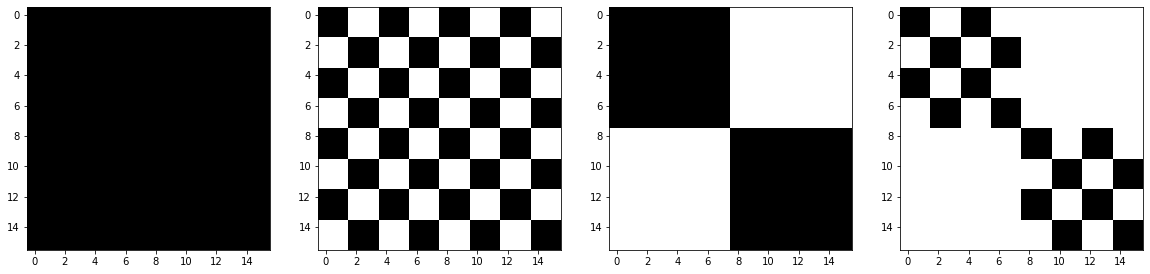

In [41]:
import matplotlib.pyplot as plt

img_mask = torch.zeros((1,8,8,1))
h_slices = (slice(0,-4),slice(-4,-2),slice(-2,None))
w_slices = (slice(0,-4),slice(-4,-2),slice(-2,None))
cnt = 0
                                                                                            
for h in h_slices:
  for w in w_slices:
    img_mask[:,h,w,:] = cnt
    cnt+=1

print(img_mask.squeeze(0).squeeze(-1))      
mask_windows = window_partition(img_mask,4)#패치 단위로 나눔
mask_windows = mask_windows.view(-1, 4*4)
#둘이 빼서 0이라면? 원래 같은 부분 -> attention 계산
#둘이 빼서 1이라면? 다른 부분 -> attention 계산 안하기 위해 마스킹 -> -100
attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)


attn_mask = attn_mask.masked_fill(attn_mask != 0, float(255.0)).masked_fill(attn_mask ==0, float(0.0))

plt.figure(1, figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(attn_mask[0], cmap='gray')
plt.subplot(1,4,2)
plt.imshow(attn_mask[1], cmap='gray')
plt.subplot(1,4,3)
plt.imshow(attn_mask[2], cmap='gray')
plt.subplot(1,4,4)
plt.imshow(attn_mask[3], cmap='gray')

In [82]:
depths = [2,2,6,2]

print(torch.linspace(0,0.1, sum([2,2,6,2])))
dpr = [x.item() for x in torch.linspace(0,0.1, sum([2,2,6,2]))]
print(dpr)

print(len(dpr))
print(dpr[sum(depths[:1]):sum(depths[:1 + 1])])
dpr[sum(depths[:0]):sum(depths[:0 + 1])]

print(depths[:3])

print(depths[:4 + 1])

tensor([0.0000, 0.0091, 0.0182, 0.0273, 0.0364, 0.0455, 0.0545, 0.0636, 0.0727,
        0.0818, 0.0909, 0.1000])
[0.0, 0.00909090880304575, 0.0181818176060915, 0.027272727340459824, 0.036363635212183, 0.045454543083906174, 0.054545458406209946, 0.06363636255264282, 0.0727272778749466, 0.08181818574666977, 0.09090909361839294, 0.10000000149011612]
12
[0.0181818176060915, 0.027272727340459824]
[2, 2, 6]
[2, 2, 6, 2]


In [21]:
x = torch.zeros(8,8)
window_size = 4
cnt = 0
for h in range(2):
  for w in range(2):
    x[h*window_size:(h+1)*window_size,w*window_size:(w+1)*window_size] = cnt
    cnt+=1

print(x)
print(torch.roll(x, shifts = (-2, -2),dims = (0,1)))

tensor([[0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1.],
        [2., 2., 2., 2., 3., 3., 3., 3.],
        [2., 2., 2., 2., 3., 3., 3., 3.],
        [2., 2., 2., 2., 3., 3., 3., 3.],
        [2., 2., 2., 2., 3., 3., 3., 3.]])
tensor([[0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0.],
        [2., 2., 3., 3., 3., 3., 2., 2.],
        [2., 2., 3., 3., 3., 3., 2., 2.],
        [2., 2., 3., 3., 3., 3., 2., 2.],
        [2., 2., 3., 3., 3., 3., 2., 2.],
        [0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0.]])
